In [1]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2019-09-26 11:50:00--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.72.82
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.72.82|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  6.49MB/s    in 3.9s    

2019-09-26 11:50:05 (6.49 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2019-09-26 11:50:11--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.74.154
Connecting to fashion-mnist.s3-website.eu-central-1.amazon

In [2]:
!ls

sample_data		   train-images-idx3-ubyte.gz
t10k-images-idx3-ubyte.gz  train-labels-idx1-ubyte.gz
t10k-labels-idx1-ubyte.gz


In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [4]:
!mkdir MNIST_Fashion
!cp *.gz MNIST_Fashion/
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_Fashion/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-labels-idx1-ubyte.gz
Extracting MNIST_Fashion/t10k-images-idx3-ubyte.gz
Extracting MNIST_Fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
#Training PArams
learning_rate = 0.0002
batch_size = 128
epochs = 100000

#Network params
image_dim = 784 #img sz is 28x28
Y_dimension = 10 # The number of classes
gen_hidd_dim = 256
disc_hidd_dim  = 256
z_noise_dim = 100

def xavier_init(shape):
  return tf.random_normal(shape = shape, stddev= 1./tf.sqrt(shape[0]/2.0))

In [0]:
weights = {
    "disc_H" : tf.Variable(xavier_init([image_dim , disc_hidd_dim])),
    "disc_final": tf.Variable(xavier_init([disc_hidd_dim,1])),
    "gen_H": tf.Variable(xavier_init([z_noise_dim , gen_hidd_dim])),
    "gen_final": tf.Variable(xavier_init([gen_hidd_dim, image_dim]))
}

bias = {
    "disc_H" : tf.Variable(xavier_init([disc_hidd_dim])),
    "disc_final": tf.Variable(xavier_init([1])),
    "gen_H": tf.Variable(xavier_init([gen_hidd_dim])),
    "gen_final": tf.Variable(xavier_init([image_dim]))
}

In [0]:
#define placeholders for external input

z_input = tf.placeholder(tf.float32, shape = [None, z_noise_dim], name = "input_noise")
x_input = tf.placeholder(tf.float32, shape = [None, image_dim], name = "real_input")
Y_input = tf.placeholder(tf.float32, shape = [None, Y_dimension], name = "Labels")



In [0]:
def Discriminator(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weights["disc_H"]), bias["disc_H"]))
  final_layer = (tf.add(tf.matmul(hidden_layer, weights["disc_final"]), bias["disc_final"]))
  disc_output = (final_layer) #NO SIGMOID IN W-GAN
  return disc_output
  

In [0]:
#Generator NW
def Generator(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weights["gen_H"]), bias["gen_H"]))
  final_layer = (tf.add(tf.matmul(hidden_layer, weights["gen_final"]), bias["gen_final"]))
  gen_output = tf.nn.sigmoid(final_layer)
  return gen_output
  

In [0]:
# building the GEN NW
with tf.name_scope("Generator") as scope:
  output_Gen = Generator(z_input) 
 
 # Building the Disc NW
with tf.name_scope("Generator") as scope:
  real_output_disc = Discriminator(x_input) 
  fake_output_disc = Discriminator(output_Gen)



In [0]:
#first kind of loss
with tf.name_scope("Discriminator_Loss") as scope:
  Discriminator_Loss = tf.reduce_mean(real_output_disc)-tf.reduce_mean(fake_output_disc)
  
with tf.name_scope("Genetator_Loss") as scope:
  Generator_Loss = -tf.reduce_mean(fake_output_disc) # due to max log(D(G(x)))

  # T-board summary
  
  Disc_loss_total = tf.summary.scalar("Disc_Total_loss", Discriminator_Loss)
  Gen_loss_total = tf.summary.scalar("Gen_loss", Generator_Loss)


In [0]:
# #second kind of loss
# with tf.name_scope("Discriminator_Loss") as scope:
#   Disc_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = real_output1_Disc, labels = tf.ones_like(real_output1_Disc)))
#   Disc_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_output1_Disc, labels = tf.zeros_like(fake_output1_Disc)))
#   Discriminator_Loss = Disc_real_loss + Disc_fake_loss

  
# with tf.name_scope("Genetator_Loss") as scope:
#   Generator_Loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_output1_Disc, labels = tf.ones_like(fake_output1_Disc)))
  
#   # Tensorboarf summary
  
# Disc_loss_real_summary = tf.summary.scalar('Disc_loss_real', Disc_real_loss)
# Disc_loss_fake_summary = tf.summary.scalar('Disc_loss_fake', Disc_fake_loss)
# Disc_loss_summary = tf.summary.scalar('Disc_total_loss', Discriminator_Loss)

# Disc_loss_total = tf.summary.merge([Disc_loss_real_summary, Disc_loss_fake_summary, Disc_loss_summary])
# Gen_loss_total = tf.summary.scalar('Gen_loss', Generator_Loss)




In [19]:
  # Define the variables

Generator_var = [weights["gen_H"], weights["gen_final"], bias["gen_H"], bias["gen_final"]]
Discriminator_var = [weights["disc_H"], weights["disc_final"], bias["disc_H"], bias["disc_final"]]

#Define the optimizer
with tf.name_scope("Optimizer_Discriminator") as scope:
  Discriminator_optimize = tf.train.RMSPropOptimizer(learning_rate = learning_rate).minimize(-Discriminator_Loss, var_list = Discriminator_var)

with tf.name_scope("Optimizer_Generator") as scope:
  Generator_optimize = tf.train.RMSPropOptimizer(learning_rate = learning_rate).minimize(Generator_Loss, var_list = Generator_var)
  
# Clipping of the Discriminator(critic) parameter
clip_disc_param = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in Discriminator_var] # Lipshutz continuity
  

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [20]:
# Initialize the variables

init = tf.global_variables_initializer()
sess = tf.Session()

sess.run(init)
writer = tf.summary.FileWriter("./log", sess.graph)

for epoch in range(epochs):
  
  for _ in range(5): # Training Discriminator more as compared to Gen thus n=5 times
    x_batch, _ = mnist.train.next_batch(batch_size)
    #Generate noise to feed Discriminator
    z_noise = np.random.uniform(-1.,1.,size = [batch_size, z_noise_dim])
    _, Disc_loss_epoch, clipping_D = sess.run([Discriminator_optimize, Discriminator_Loss, clip_disc_param], feed_dict = {x_input:x_batch, z_input:z_noise})
  
  
  _, Gen_loss_epoch = sess.run([Generator_optimize, Generator_Loss], feed_dict = {z_input:z_noise})  
  
  #Running the Discriminator summary
  summary_Disc_loss = sess.run(Disc_loss_total, feed_dict = {x_input:x_batch, z_input:z_noise})
  # Adding the Discriminator summary
  writer.add_summary(summary_Disc_loss, epoch)
  
  #Running the Generator summary
  summary_Gen_loss = sess.run(Gen_loss_total, feed_dict = {z_input:z_noise})
  # Adding the Generator summary
  writer.add_summary(summary_Gen_loss, epoch)
  
  if epoch % 2000 == 0:
    print("Steps: {0}: Generator Loss: {1}, Discriminator Loss:{2}".format(epoch, Gen_loss_epoch, Disc_loss_epoch))
  
  


Steps: 0: Generator Loss: -0.023887667804956436, Discriminator Loss:-0.0038589034229516983
Steps: 2000: Generator Loss: -0.31157830357551575, Discriminator Loss:0.026659011840820312
Steps: 4000: Generator Loss: -0.10638358443975449, Discriminator Loss:0.01324254460632801
Steps: 6000: Generator Loss: 0.324923038482666, Discriminator Loss:0.031112223863601685
Steps: 8000: Generator Loss: 0.20711688697338104, Discriminator Loss:0.01455014944076538
Steps: 10000: Generator Loss: 0.177816241979599, Discriminator Loss:-0.014074623584747314
Steps: 12000: Generator Loss: -0.2827920913696289, Discriminator Loss:0.003461509943008423
Steps: 14000: Generator Loss: 0.6470275521278381, Discriminator Loss:-0.025451302528381348
Steps: 16000: Generator Loss: -0.19246512651443481, Discriminator Loss:0.012396514415740967
Steps: 18000: Generator Loss: 0.07581478357315063, Discriminator Loss:0.0021575093269348145
Steps: 20000: Generator Loss: 0.3721214532852173, Discriminator Loss:0.007981479167938232
Steps

In [21]:
print(x_batch.shape)
print(x_input.shape)
print(z_input.shape)
print(z_noise.shape)



(128, 784)
(?, 784)
(?, 100)
(128, 100)


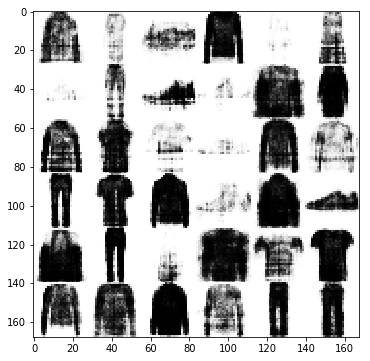

In [22]:
#Testing
# Generate images from noise, using the generator network

n = 6
canvas = np.empty((28*n, 28*n))
for i in range(n):
  #Noise input
  z_noise = np.random.uniform(-1.,1., size = [batch_size, z_noise_dim])
  # Generate image from noise
  g = sess.run(output_Gen, feed_dict = {z_input:z_noise})
  # Reverse colors for better display
  g=-1*(g-1)
  for j in range(n):
    #Draw the generated digits
    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = g[j].reshape([28, 28])
    
plt.figure(figsize = (n,n))
plt.imshow(canvas, origin = "upper", cmap = "gray")
plt.show()